# **Project 4: Kernels**
## Amaan Rahman  & Daniel Mezhiborsky
### ECE 474 
### Professor Keene

## **Abstract**
Linear parametric models can be represented with a dual-representation, where predictions are based on a linear combination of kernel functions evaluated at the training dataset. This leads into mapping input vectors into a feature space, where the mapping can be subsituted with various kernels known as kernel substitution. 

In this experiment, gaussian processes are investigated. The perspective with gaussian processes is to treat the prior distibution over a finite function space due to considering a discrete set of input values $\mathbf{x}_n$. Gaussian processes can be utilized for linear regression tasks, and a rederived predictive distribution can be generated taking advantage of the kernel method: 

$$
p(\mathbf{t}) = \int p(\mathbf{t} | \mathbf{y})p(\mathbf{y})d\mathbf{y} = \mathcal{N}(\mathbf{t}|\mathbf{0}, \mathbf{C})
$$

*Radial Basis Function (RBF) Kernel:*

$$
k(\mathbf{x}_n, \mathbf{x}_m) = exp\left[-\frac{\left(\mathbf{x}_n\mathbf{x}_m + \mathbf{x}_m^{\text{T}}\mathbf{x}_m - 2\mathbf{x}_n^{\text{T}}\mathbf{x}_m\right)}{2\sigma^2}\right]
$$

*Gram Matrix* ($\mathbf{x}=\mathbf{x}^{\prime}=\mathbf{x}_{train}$):

$$
\mathbf{K} = \begin{bmatrix}
k(\mathbf{x}_1, \mathbf{x}^{\prime}_1) & k(\mathbf{x}_2, \mathbf{x}^{\prime}_2) & ⋯ & k(\mathbf{x}_1, \mathbf{x}^{\prime}_m) \\
k(\mathbf{x}_2, \mathbf{x}^{\prime}_1) & k(\mathbf{x}_2, \mathbf{x}^{\prime}_1) & \cdots & k(\mathbf{x}_2, \mathbf{x}^{\prime}_m) \\
\vdots & \vdots & \ddots & \vdots \\
k(\mathbf{x}_n, \mathbf{x}^{\prime}_1) & k(\mathbf{x}_n, \mathbf{x}^{\prime}_2) & \cdots & k(\mathbf{x}_n, \mathbf{x}^{\prime}_m)
\end{bmatrix} = (k(\mathbf{x}_n, \mathbf{x}^{\prime}_m))\in\mathbb{R}^{m \times n}
$$

*Covariance Matrix:*

$$
C = \mathbf{K} + \frac{1}{\beta}\mathbf{I}
$$

*Predictive Gaussian Distribution Means and Covariance:*

$$
c = k(\mathbf{x}_{N+1}, \mathbf{x}_{N+1}) + \beta^{-1}
$$

$$
m(\mathbf{x}_{N+1}) = \mathbf{k}^{\text{T}}\mathbf{C}_{N}^{-1}\mathbf{k}
$$

$$
\sigma^2(\mathbf{x}_{N+1}) = c - \mathbf{k}^{\text{T}}\mathbf{C}_N^{-1}\mathbf{k}
$$

$$
\text{where }\mathbf{k}\text{ is evaluated on train and test data }(\mathbf{x}_{N+1}=\mathbf{x}_{test})
$$

# Extra credit
SVM with the kernel trick can depend on hyperparameters - in the case of the RBF kernel, those are C and gamma. Grid search is a simple way to find optimal hyperparameters. In the link below, we implement grid search for an SVM classifier for the datasets used in project 3.

The SVM with grid-searched C and gamma outperforms the other models from project 3.

https://www.kaggle.com/dmezh0/notebook256ea69982?scriptVersionId=83789241&cellId=22

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import multivariate_normal, norm
from tqdm import trange

# Data Generator

In [ ]:
class Data(object):
    '''
    Sample data generator class
    '''
    def __init__(self, fn_type, x_rng, num_samples, epsilon):
        noise = np.random.normal(0, epsilon, size=(num_samples, 1)) # gaussian noise

        self.indicies = np.arange(num_samples)
        self.x = np.linspace(x_rng[0], x_rng[1], num_samples)
        self.x = np.atleast_2d(self.x).T
        self.t = 1 * np.sin(2 * np.pi * self.x) + noise
        self.t_Truth = 1 * np.sin(2 * np.pi * self.x)

    def _getBatch(self, batch_size):
        '''
        Get random batch of data from train dataset

        Parameters
        ----------

        batch_size: size of extracted random batch
        '''
        batch_ind = np.random.choice(self.indicies, size=batch_size)
        return (
            self.x[batch_ind],
            self.t[batch_ind].flatten()
        )

# Kernel

In [ ]:
class GaussianProcess(object): 
    '''
    Gaussian Process class to treat the prior as a distribution of gaussian 
    functions, and taking advantage of kernel methods to map the input space
    into a feature space
    '''
    
    def __init__(self, beta):
        self.beta = beta

    def __kernel(self, x, x_prime, sigma = 0.3):
        '''
        Radial Basis Function (RBF) or Gaussian kernel

        Parameters
        ----------
        x: first input vector

        x_prime: second input vector

        sigma: standard deviation of RBF kernel
        '''
        sqdist = np.sum(x**2,1).reshape(-1,1) + \
             np.sum(x_prime**2,1) - 2*np.dot(x, x_prime.T)
        return np.exp(-0.5 * sqdist / (sigma ** 2))
    
    def _predict(self, train, test, enable_plot = False, ax = None):
        '''
        Generate predictive distribution based on gaussian process and kernel methods
        
        Parameters
        ----------
        train: input and target train data

        test: input and target test data

        enable_plot: trigger plot display

        ax: complies with `enable_plot` argument
        '''
        x_train, t_train = train
        x_test, t_test = test

        K = self.__kernel(x_train, x_train)                     # gram matrix
        C = K + ((1 / self.beta) * np.eye(K.shape[0]))          # covariance matrix
        C_inv = np.linalg.inv(C)
        k = self.__kernel(x_train, x_test)                      # predictive kernel
        c = self.__kernel(x_test, x_test) + (1 / self.beta)

        mu = k.T @ C_inv @ t_train.T  
        covar = c - k.T @ C_inv @ k
        sigma = np.sqrt(np.diag(covar))

        if enable_plot: 
            ax.fill_between(x_test.flatten(), mu + sigma, mu - sigma, alpha=0.75, color='pink', lw=0)

            ax.plot(x_test.flatten(), mu, color='red')
            ax.plot(x_test.flatten(), t_test.flatten(), color='lime')
            ax.plot(x_train, t_train, 'o', color='blue', mfc='none')

            ax.set_xticks([0, 1])
            ax.set_yticks([-1, 0, 1])
            ax.set_ylim(-1.5, 1.5)
            ax.set_xlim(-0.1, 1.1)
            ax.set_xlabel('x')
            ax.set_ylabel('t')
            ax.text(0.8, 1, f'N = {x_train.shape[0]}')
            

## Regression Prediction with Gaussian Processes

100%|██████████| 4/4 [00:00<00:00, 36.54it/s]


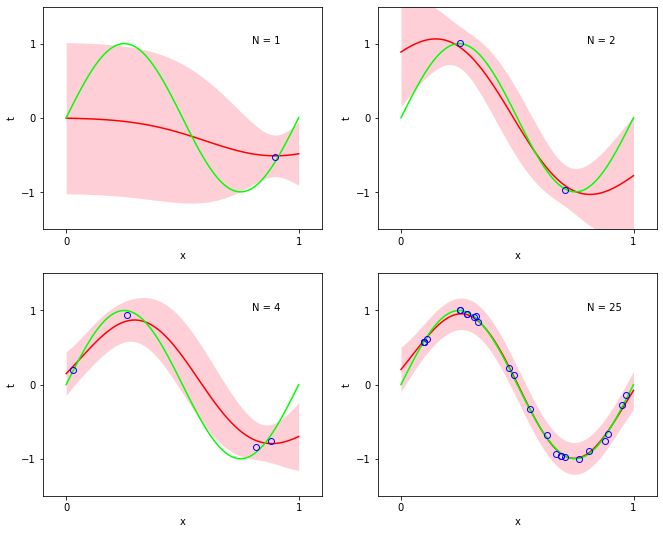

In [ ]:
# environment setup
NUM_SAMPLES = 100
BATCH_SIZE = [1, 2, 4, 25]
BETA = 25

# generate sample train and test data
noise_std = 1/BETA
data = Data(
    fn_type = 'SIN',
    x_rng = (0, 1),
    num_samples = NUM_SAMPLES,
    epsilon = noise_std
)
x_test = data.x
t_test = data.t_Truth

# init GaussianProcess for regression 
fig = plt.figure(figsize=(11, 9))
GP = GaussianProcess(beta = BETA)

# predict and plot results
plt_shape = [2, 2, 0]
for i in trange(len(BATCH_SIZE)):
    plt_shape[2] += 1

    # get batch of train data
    observations = BATCH_SIZE[i]
    x_train, t_train = data._getBatch(observations)

    # predict
    ax = fig.add_subplot(*plt_shape)
    GP._predict(
        train = (x_train, t_train),
        test = (x_test, t_test),
        enable_plot = True,
        ax = ax
    )
print()